In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Global features
        self.global_features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 4096),  # Adjusted Linear layer
            nn.ReLU(),
            nn.Linear(4096, 128)
        )
        # Local features with adaptive pooling
        self.local_features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((28, 28))  # downsample to 28x28 or another size of your choice
        )

    def forward(self, x):
        global_feat = self.global_features(x)
        local_feat = self.local_features(x)
        return global_feat, local_feat

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Adjust the combined linear input size
        self.combine = nn.Sequential(
            nn.Linear(128 + 64, 512),  # Adjusted input size (128 for global features + 64 for local features)
            nn.ReLU(),
            nn.Linear(512, 1)  # Binary classification: real or fake
        )

    def forward(self, global_features, local_features):
        global_features_tiled = global_features.unsqueeze(2).unsqueeze(3).repeat(1, 1, 28, 28)
        #print("Tiled Global Features Shape:", global_features_tiled.shape)  # Shape after tiling

        combined = torch.cat([global_features_tiled, local_features], dim=1)
        #print("Combined Shape:", combined.shape)  # Shape after concatenating

        combined = combined.view(combined.size(0) * combined.size(2) * combined.size(3), -1)
        #print("Reshaped Combined Shape:", combined.shape)  # Shape after reshaping

        return self.combine(combined).squeeze()

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import numpy as np
import matplotlib.pyplot as plt  # Make sure this line is included
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import ImageFolder


# Data preprocessing
transform = transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.RandomCrop(64, padding=4),  # Adjusted to 224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

def is_png_file(filename):
    return filename.endswith('.png')

full_dataset = torchvision.datasets.ImageFolder(root='/Users/sadianasrintisha/Desktop/data', transform=transform,is_valid_file=is_png_file)

train_size = int(0.8 * len(full_dataset))  # Let's say you want 80% for training
test_size = len(full_dataset) - train_size

unlabeled_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



encoder = Encoder().to(device)
discriminator = Discriminator().to(device)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
encoder_scheduler = StepLR(encoder_optimizer, step_size=10, gamma=0.7)
discriminator_scheduler = StepLR(discriminator_optimizer, step_size=10, gamma=0.7)
criterion = nn.BCEWithLogitsLoss()




cpu


In [3]:
print(f"Size of unlabeled (train) dataset: {len(unlabeled_dataset)} samples")
print(f"Size of test dataset: {len(test_dataset)} samples")


Size of unlabeled (train) dataset: 70439 samples
Size of test dataset: 17610 samples


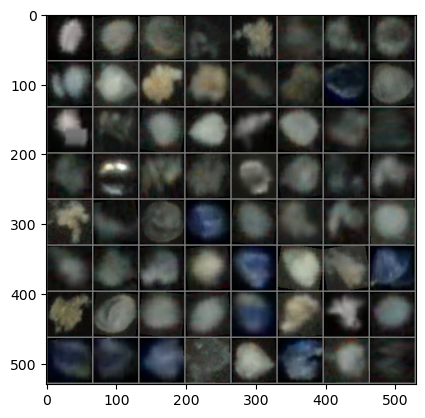

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision  # Make sure to import torchvision

# Take a batch of data and convert it to grid
dataiter = iter(unlabeled_dataloader)
images, _ = dataiter.__next__()  # Changed this line
grid = torchvision.utils.make_grid(images)

# Function to un-normalize and display the image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display
imshow(grid)



In [5]:
num_epochs = 20
losses = []  # Add this before the training loop

for epoch in range(num_epochs):
    for images, _ in unlabeled_dataloader:
        images = images.to(device)
        global_features, local_features = encoder(images)

        # Positive samples: local and global features from the same image
        positive_labels = torch.ones(local_features.size(0) * local_features.size(2) * local_features.size(3), device=device)
        positive_predictions = discriminator(global_features, local_features)

        # Negative samples: mix local features and global features
        negative_labels = torch.zeros(local_features.size(0) * local_features.size(2) * local_features.size(3), device=device)
        negative_predictions = discriminator(global_features[torch.randperm(local_features.size(0))], local_features)

        # Compute loss and update weights
        loss_positive = criterion(positive_predictions, positive_labels)
        loss_negative = criterion(negative_predictions, negative_labels)

        loss = loss_positive + loss_negative
        losses.append(loss.item())


        encoder_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        loss.backward()
        encoder_optimizer.step()
        discriminator_optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")



Epoch 1/20, Loss: 1.3862946033477783
Epoch 2/20, Loss: 1.3862943649291992
Epoch 3/20, Loss: 1.3862946033477783
Epoch 4/20, Loss: 1.3862943649291992
Epoch 5/20, Loss: 1.3862943649291992
Epoch 6/20, Loss: 1.3862674236297607
Epoch 7/20, Loss: 1.385237216949463
Epoch 8/20, Loss: 1.3852571249008179
Epoch 9/20, Loss: 1.3851358890533447
Epoch 10/20, Loss: 1.3851780891418457
Epoch 11/20, Loss: 1.3848061561584473
Epoch 12/20, Loss: 1.3849036693572998
Epoch 13/20, Loss: 1.3849966526031494
Epoch 14/20, Loss: 1.3849194049835205
Epoch 15/20, Loss: 1.38519287109375
Epoch 16/20, Loss: 1.384986400604248
Epoch 17/20, Loss: 1.384873390197754
Epoch 18/20, Loss: 1.3850327730178833
Epoch 19/20, Loss: 1.3849784135818481
Epoch 20/20, Loss: 1.3849704265594482


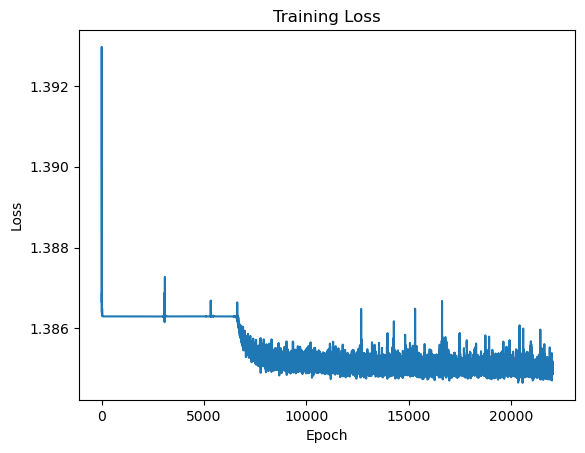

In [6]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
##used MLP

losses_1 = []
class Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(128, 512),  # Increased the number of neurons
            nn.ReLU(),
            nn.Dropout(p=0.5),   # Added dropout for regularization
            nn.Linear(512, 256), # Added an additional hidden layer
            nn.ReLU(),
            nn.Dropout(p=0.5),   # Added another dropout layer
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# Unfreeze encoder parameters for fine-tuning
for param in encoder.parameters():
    param.requires_grad = True


classifier = Classifier().to(device)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.001)
classification_criterion = nn.CrossEntropyLoss()

labeled_dataloader = torch.utils.data.DataLoader(
    ImageFolder(root='/Users/sadianasrintisha/Desktop/data', transform=transform),
    batch_size=64, shuffle=True
)


num_epochs_classifier = 50

for epoch in range(num_epochs_classifier):
    for images, labels in labeled_dataloader:
        images, labels = images.to(device), labels.to(device)
        global_features, _ = encoder(images)
        predictions = classifier(global_features)
        loss = classification_criterion(predictions, labels)

        losses_1.append(loss.item())

        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs_classifier}, Loss: {loss.item()}")





Epoch 1/50, Loss: 0.6706815958023071
Epoch 2/50, Loss: 0.6734206676483154
Epoch 3/50, Loss: 0.6742688417434692
Epoch 4/50, Loss: 0.7170524001121521
Epoch 5/50, Loss: 0.6829752326011658
Epoch 6/50, Loss: 0.7227503061294556
Epoch 7/50, Loss: 0.7122458815574646
Epoch 8/50, Loss: 0.6943668723106384
Epoch 9/50, Loss: 0.6786328554153442
Epoch 10/50, Loss: 0.6811280250549316
Epoch 11/50, Loss: 0.670337975025177
Epoch 12/50, Loss: 0.682375431060791
Epoch 13/50, Loss: 0.6940582394599915
Epoch 14/50, Loss: 0.6836491823196411
Epoch 15/50, Loss: 0.6352563500404358
Epoch 16/50, Loss: 0.6903389096260071
Epoch 17/50, Loss: 0.6929053664207458
Epoch 18/50, Loss: 0.6563843488693237
Epoch 19/50, Loss: 0.6671126484870911
Epoch 20/50, Loss: 0.6780028343200684
Epoch 21/50, Loss: 0.6888709664344788
Epoch 22/50, Loss: 0.7299710512161255
Epoch 23/50, Loss: 0.6871235370635986
Epoch 24/50, Loss: 0.6727139949798584
Epoch 25/50, Loss: 0.6367608308792114
Epoch 26/50, Loss: 0.7196255326271057
Epoch 27/50, Loss: 0.66

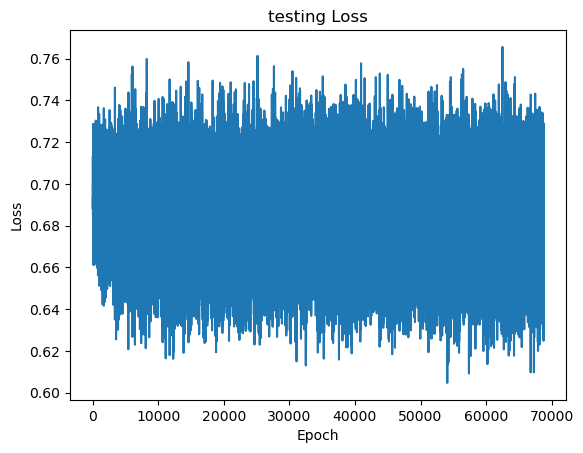

In [11]:
plt.plot(losses_1)
plt.title('testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

encoder.eval()
classifier.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        global_features, _ = encoder(images)
        predictions = classifier(global_features)
        _, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total}%')





Accuracy of the network on test images: 57.27427597955707%


Classification Report:
              precision    recall  f1-score   support

      Class1       0.59      0.50      0.54      8962
      Class2       0.56      0.64      0.60      8648

    accuracy                           0.57     17610
   macro avg       0.57      0.57      0.57     17610
weighted avg       0.57      0.57      0.57     17610



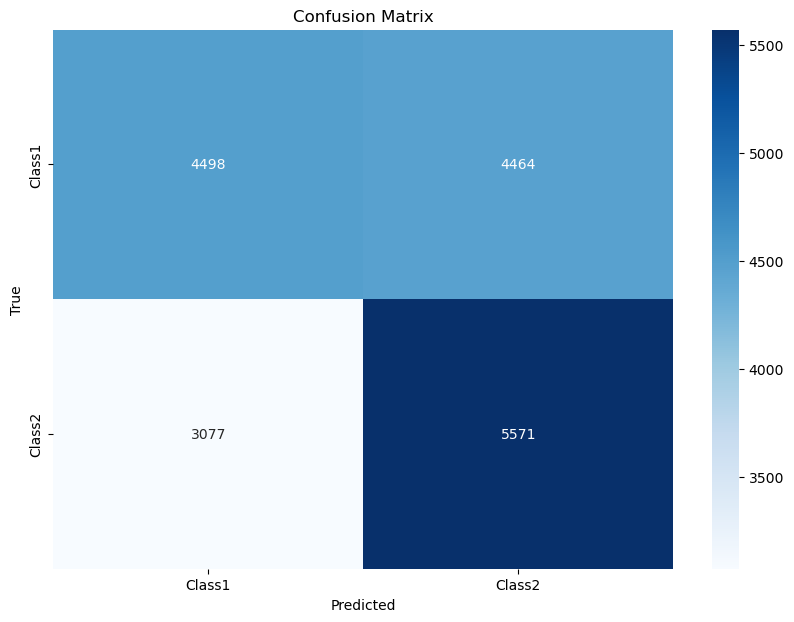

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Iterate over test data to get predictions and true labels
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        global_features, _ = encoder(images)
        predictions = classifier(global_features)
        _, predicted = torch.max(predictions.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the classification report and confusion matrix
report = classification_report(all_labels, all_preds, target_names=["Class1", "Class2"])  # Replace "Class1" and "Class2" with your actual class names
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print classification report
print("Classification Report:")
print(report)

# Plot confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=["Class1", "Class2"], yticklabels=["Class1", "Class2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
